# 一、导入需要用到的库

In [1]:
import tensorflow as tf
if tf.__version__ != '1.0.0':
    print("please check the version of tensorflow!")
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

/Users/andy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


please check the version of tensorflow!


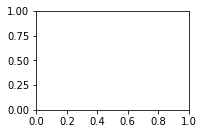

In [2]:
#gridspec用法示例
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[0, 0])

# 二、准备相关工具

In [3]:
#该函数将给出权重初始化的方法
def variable_init(size):
    in_dim = size[0]

    #计算随机生成变量所服从的正态分布标准差
    w_stddev = 1. / tf.sqrt(in_dim / 2.)#msra初始化
    return tf.random_normal(shape=size, stddev=w_stddev)

In [4]:
#该函数用于输出生成图片
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


# 三、构建生成器和判别器

## 1、参数定义

In [5]:
#定义判别器的权重矩阵和偏置项向量，由此可知判别网络为三层全连接网络
D_W1 = tf.Variable(variable_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(variable_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

#定义生成器的权重与偏置项，输入层为100个神经元且接受随机噪声，
#输出层为784个神经元，并输出手写字体图片，生成网络根据原论文为三层全连接网络
G_W1 = tf.Variable(variable_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(variable_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

## 2、定义G&D 

In [6]:
#定义生成器
def generator(z):
    
    #第一层先计算 y=z*G_W1+G-b1,然后投入激活函数计算G_h1=ReLU（y）,G_h1 为第二次层神经网络的输出激活值
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    
    #以下两个语句计算第二层传播到第三层的激活结果，第三层的激活结果是含有784个元素的向量，该向量转化28×28就可以表示图像
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob

#定义判别器
def discriminator(x):
    
    #计算D_h1=ReLU（x*D_W1+D_b1）,该层的输入为含784个元素的向量
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    
    #计算第三层的输出结果。因为使用的是Sigmoid函数，则该输出结果是一个取值为[0,1]间的标量（见上述权重定义）
    #即判别输入的图像到底是真（=1）还是假（=0）
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    
    #返回判别为真的概率和第三层的输入值，输出D_logit是为了将其输入tf.nn.sigmoid_cross_entropy_with_logits()以构建损失函数
    return D_prob, D_logit

# 四、数据准备

In [7]:
#定义输入矩阵的占位符，输入层单元为784，None代表批量大小的占位，X代表输入的真实图片。占位符的数值类型为32位浮点型
X = tf.placeholder(tf.float32, shape=[None, 784])

#定义生成器的输入噪声为100维度的向量组，None根据批量大小确定
Z = tf.placeholder(tf.float32, shape=[None, 100])

#定义一个可以生成m*n阶随机矩阵的函数，该矩阵的元素服从均匀分布，随机生成的z就为生成器的输入
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

mnist = input_data.read_data_sets("./MNIST_data", one_hot=True)


#选择训练的批量大小和随机生成噪声的维度
mb_size = 128
Z_dim = 100

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


# 五、建模

In [8]:
#输入随机噪声z而输出生成样本
G_sample = generator(Z)

#分别输入真实图片和生成的图片，并投入判别器以判断真伪
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# 六、定义损失函数

#### 交叉熵损失函数
sigmoid_cross_entropy_with_logits函数的输入是logits和targets，logits就是神经网络模型中的 W * X+b矩阵，且不需要经过Sigmoid激活函数。而targets的shape和logits相同，即正确的标注值。若令x = logits、 z = labels，那么该函数的表达式为z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))

In [9]:
#以下为原论文的判别器损失和生成器损失，但本实现并没有使用该损失函数
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# 我们使用交叉熵作为判别器和生成器的损失函数，因为sigmoid_cross_entropy_with_logits内部会对预测输入执行Sigmoid函数，
#所以我们取判别器最后一层未投入激活函数的值，即D_h1*D_W2+D_b2。
#tf.ones_like(D_logit_real)创建维度和D_logit_real相等的全是1的标注，真实图片。
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))

#损失函数为两部分，即E[log(D(x))]+E[log(1-D(G(z)))]，将真的判别为假和将假的判别为真
D_loss = D_loss_real + D_loss_fake

#同样使用交叉熵构建生成器损失函数
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

#定义判别器和生成器的优化方法为Adam算法，关键字var_list表明最小化损失函数所更新的权重矩阵
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

# 七、run

In [10]:
#打开一个会话运行计算图
sess = tf.Session()

#初始化所有定义的变量
sess.run(tf.global_variables_initializer())

#如果当前目录下不存在out文件夹，则创建该文件夹
if not os.path.exists('out/'):
    os.makedirs('out/')

#初始化，并开始迭代训练，100W次
i = 0
for it in range(20000):
    
    #每2000次输出一张生成器生成的图片
    if it % 2000 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
    
    #next_batch抽取下一个批量的图片，该方法返回一个矩阵，即shape=[mb_size，784]，每一行是一张图片，共批量大小行
    X_mb, _ = mnist.train.next_batch(mb_size)
    
    #投入数据并根据优化方法迭代一次，计算损失后返回损失值
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})


    #每迭代2000次输出迭代数、生成器损失和判别器损失
    if it % 2000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 0
D loss: 1.804
G_loss: 2.061

Iter: 2000
D loss: 0.04873
G_loss: 5.286

Iter: 4000
D loss: 0.05339
G_loss: 7.034

Iter: 6000
D loss: 0.2122
G_loss: 3.883

Iter: 8000
D loss: 0.5445
G_loss: 3.723

Iter: 10000
D loss: 0.381
G_loss: 2.996

Iter: 12000
D loss: 0.4478
G_loss: 2.703

Iter: 14000
D loss: 0.5556
G_loss: 2.423

Iter: 16000
D loss: 0.6248
G_loss: 2.305

Iter: 18000
D loss: 0.7022
G_loss: 1.886

